# **ESSAY MULTICLASS**

## **Preliminary steps**

In [1]:
### PACKAGES

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

In [2]:
### FUNCTIONS

from src.configs import constants, ml_config, names
from src.libs import preprocessing, evaluation, visualization
from src.embedding.tf_idf import TfIdfEmbedding
from src.embedding.punctuation import PunctuationEmbedding
from src.classifier.classifier import LightGBMClassifier, RFClassifier, NBClassifier

## **DATA**

In [3]:
### LOAD DATA

df_poetry_gpt = preprocessing.load_dataset(source="GPT", type="POETRY")
df_poetry_bard = preprocessing.load_dataset(source="BARD", type="POETRY")
df_poetry_human = preprocessing.load_dataset(source="Human", type="POETRY")

df_essay_gpt = preprocessing.load_dataset(source="GPT", type="ESSAY")
df_essay_bard = preprocessing.load_dataset(source="BARD", type="ESSAY")
df_essay_human = preprocessing.load_dataset(source="Human", type="ESSAY")

df_story_gpt = preprocessing.load_dataset(source="GPT", type="STORY")
df_story_bard = preprocessing.load_dataset(source="BARD", type="STORY")
df_story_human = preprocessing.load_dataset(source="Human", type="STORY")

Time taken to load dataset: 0.014808893203735352 seconds
Time taken to load dataset: 0.012117147445678711 seconds
Time taken to load dataset: 0.3470017910003662 seconds
Time taken to load dataset: 0.017599105834960938 seconds
Time taken to load dataset: 0.017595529556274414 seconds
Time taken to load dataset: 0.09989738464355469 seconds
Time taken to load dataset: 0.02495574951171875 seconds
Time taken to load dataset: 0.014901876449584961 seconds
Time taken to load dataset: 0.026621341705322266 seconds


In [4]:
### GET TRAIN SPLIT

df_train_poetry_gpt, df_test_poetry_gpt = preprocessing.train_valid_split(df_poetry_gpt)
df_train_poetry_bard, df_test_poetry_bard = preprocessing.train_valid_split(
    df_poetry_bard
)
df_train_poetry_human, df_test_poetry_human = preprocessing.train_valid_split(
    df_poetry_human
)

df_train_essay_gpt, df_test_essay_gpt = preprocessing.train_valid_split(df_essay_gpt)
df_train_essay_bard, df_test_essay_bard = preprocessing.train_valid_split(df_essay_bard)
df_train_essay_human, df_test_essay_human = preprocessing.train_valid_split(
    df_essay_human
)

df_train_story_gpt, df_test_story_gpt = preprocessing.train_valid_split(df_story_gpt)
df_train_story_bard, df_test_story_bard = preprocessing.train_valid_split(df_story_bard)
df_train_story_human, df_test_story_human = preprocessing.train_valid_split(
    df_story_human
)

In [5]:
### GET FULL DATASETS

df_train_essay = preprocessing.get_essay_dataset(
    df_train_essay_gpt,
    df_train_essay_bard,
    df_train_essay_human,
    samples_per_source=min(
        len(df_train_essay_gpt), len(df_train_essay_bard), len(df_train_essay_human)
    ),
)
df_test_essay = preprocessing.get_essay_dataset(
    df_test_essay_gpt,
    df_test_essay_bard,
    df_test_essay_human,
    samples_per_source=None,
)

df_test_poetry = preprocessing.get_poetry_dataset(
    df_test_poetry_gpt,
    df_test_poetry_bard,
    df_test_poetry_human,
    samples_per_source=None,
)

df_test_story = preprocessing.get_story_dataset(
    df_test_story_gpt, df_test_story_bard, df_test_story_human, samples_per_source=None
)

In [6]:
### SPLIT FEATURES AND LABELS

X_train_essay, y_train_essay = preprocessing.split_features_and_labels(df_train_essay)
X_test_essay, y_test_essay = preprocessing.split_features_and_labels(df_test_essay)
X_test_poetry, y_test_poetry = preprocessing.split_features_and_labels(df_test_poetry)
X_test_story, y_test_story = preprocessing.split_features_and_labels(df_test_story)

## **CLASSIFICATION USING PUNCTUATION & RANDOM FOREST**

In [7]:
ID_EXPERIMENT = 211

In [8]:
### EMBEDDING

embedding_211 = PunctuationEmbedding(ID_EXPERIMENT)

X_train_essay_211 = embedding_211.transform(X=X_train_essay)
X_test_essay_211 = embedding_211.transform(X=X_test_essay)
X_test_poetry_211 = embedding_211.transform(X=X_test_poetry)
X_test_story_211 = embedding_211.transform(X=X_test_story)

In [9]:
### CLASSIFIER

classifier_211 = LightGBMClassifier(ID_EXPERIMENT)

classifier_211.train(X_train=X_train_essay_211, y_train=y_train_essay)

metrics_essay_211 = classifier_211.evaluate(X_test_essay_211, y_test_essay)
metrics_poetry_211 = classifier_211.evaluate(X_test_poetry_211, y_test_poetry)
metrics_story_211 = classifier_211.evaluate(X_test_story_211, y_test_story)

print(f"Metrics on essay: {metrics_essay_211}")
print(f"Metrics on poetry: {metrics_poetry_211}")
print(f"Metrics on story: {metrics_story_211}")

Metrics on essay: {'accuracy': 0.7158671586715867, 'precision': 0.44126984126984126, 'recall': 0.6555330634278003, 'f1': 0.4489231698534024}
Metrics on poetry: {'accuracy': 0.5426136363636364, 'precision': 0.3275215297036929, 'recall': 0.2502660861151427, 'f1': 0.24051501434948264}
Metrics on story: {'accuracy': 0.6363636363636364, 'precision': 0.5198412698412699, 'recall': 0.5555555555555555, 'f1': 0.5206971677559913}


In [10]:
### INTERPRETABILITY - FEATURE IMPORTANCE

dim_names_211 = embedding_211.map_dimensions_to_names()
feature_importances_211 = classifier_211.get_feature_importance()
most_important_features_211 = np.argsort(feature_importances_211)[-10:][::-1]
for i in most_important_features_211:
    print(f"{dim_names_211[i]}: {feature_importances_211[i]}")

ratio_words_per_sentence: 2092
ratio_punctuations: 1999
ratio_odd_characters: 1944


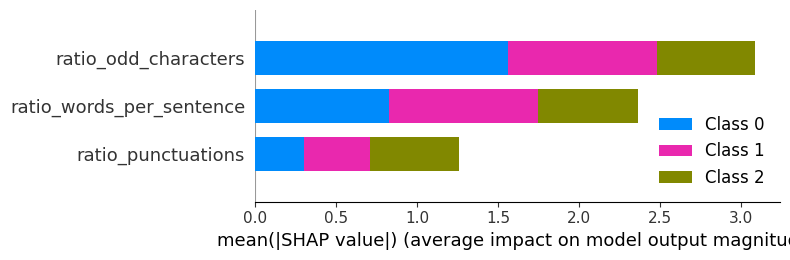

In [11]:
### INTERPRETABILITY - SHAP VALUES

explainer_211 = shap.Explainer(classifier_211.classifier)

if hasattr(X_test_essay_211, "toarray"):
    X_test_essay_211 = X_test_essay_211.toarray()

# Calculate SHAP values
shap_values_211 = explainer_211(X_test_essay_211)

# Visualize the SHAP values
shap.summary_plot(shap_values_211, X_test_essay_211, feature_names=dim_names_211)

## **CLASSIFICATION USING TF-IDF & LGBM**

In [12]:
ID_EXPERIMENT = 111

In [13]:
### EMBEDDING

embedding_111 = TfIdfEmbedding(ID_EXPERIMENT)

embedding_111.fit(X=X_train_essay)

X_train_essay_111 = embedding_111.transform(X=X_train_essay)
X_test_essay_111 = embedding_111.transform(X=X_test_essay)
X_test_poetry_111 = embedding_111.transform(X=X_test_poetry)
X_test_story_111 = embedding_111.transform(X=X_test_story)

In [14]:
### CLASSIFIER

classifier_111 = LightGBMClassifier(ID_EXPERIMENT)

classifier_111.train(X_train=X_train_essay_111, y_train=y_train_essay)

metrics_essay_111 = classifier_111.evaluate(X_test_essay_111, y_test_essay)
metrics_poetry_111 = classifier_111.evaluate(X_test_poetry_111, y_test_poetry)
metrics_story_111 = classifier_111.evaluate(X_test_story_111, y_test_story)

print(f"Metrics on essay: {metrics_essay_111}")
print(f"Metrics on poetry: {metrics_poetry_111}")
print(f"Metrics on story: {metrics_story_111}")

Metrics on essay: {'accuracy': 0.981549815498155, 'precision': 0.9430839002267574, 'recall': 0.8292847503373819, 'f1': 0.8558758314855875}
Metrics on poetry: {'accuracy': 0.1534090909090909, 'precision': 0.3344771516197873, 'recall': 0.3402612481857765, 'f1': 0.09429801894918173}
Metrics on story: {'accuracy': 0.5272727272727272, 'precision': 0.572463768115942, 'recall': 0.5333333333333333, 'f1': 0.5119497924547013}


In [15]:
### INTERPRETABILITY - FEATURE IMPORTANCE

dim_names_111 = embedding_111.map_dimensions_to_names()
feature_importances_111 = classifier_111.get_feature_importance()
most_important_features_111 = np.argsort(feature_importances_111)[-10:][::-1]
for i in most_important_features_111:
    print(f"{dim_names_111[i]}: {feature_importances_111[i]}")

really: 302
just: 269
help: 226
make: 216
believe: 175
like: 175
know: 165
conclusion: 156
specific: 156
going: 125


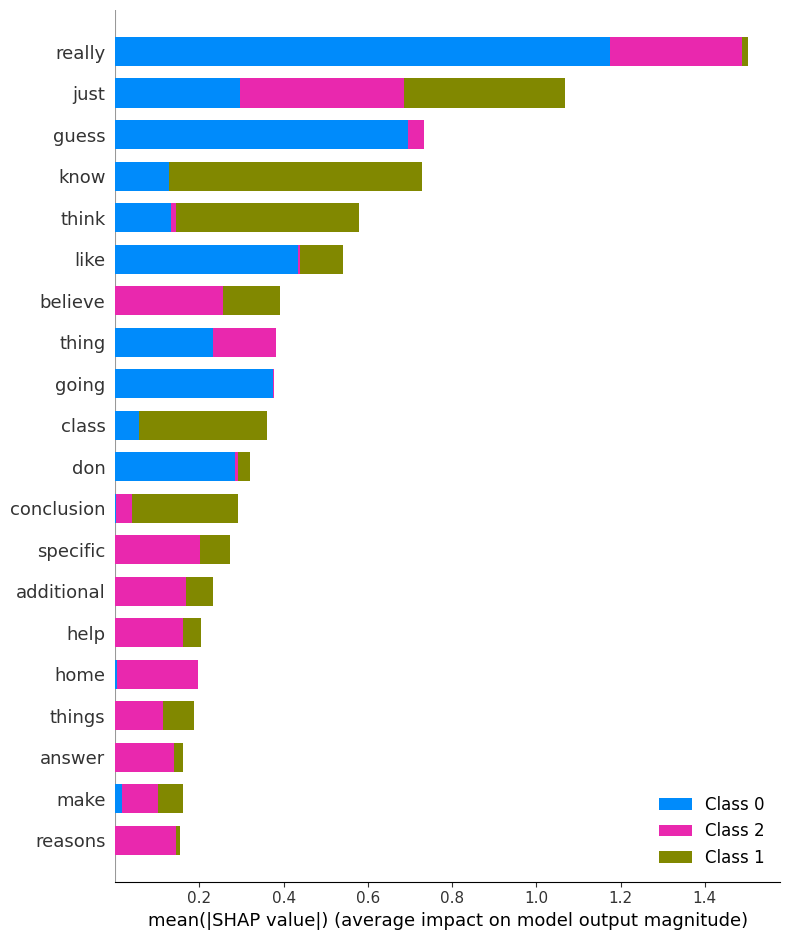

In [16]:
### INTERPRETABILITY - SHAP VALUES

explainer_111 = shap.Explainer(classifier_111.classifier)

if hasattr(X_test_essay_111, "toarray"):
    X_test_essay_111 = X_test_essay_111.toarray()

# Calculate SHAP values
shap_values_111 = explainer_111(X_test_essay_111)


# Visualize the SHAP values
shap.summary_plot(shap_values_111, X_test_essay_111, feature_names=dim_names_111)

## **CLASSIFICATION USING TF-IDF & RANDOM FOREST**

In [17]:
ID_EXPERIMENT = 121

In [18]:
### EMBEDDING

embedding_121 = TfIdfEmbedding(ID_EXPERIMENT)

embedding_121.fit(X=X_train_essay)

X_train_essay_121 = embedding_121.transform(X=X_train_essay)
X_test_essay_121 = embedding_121.transform(X=X_test_essay)
X_test_poetry_121 = embedding_121.transform(X=X_test_poetry)
X_test_story_121 = embedding_121.transform(X=X_test_story)

In [19]:
### CLASSIFIER

classifier_121 = RFClassifier(ID_EXPERIMENT)

classifier_121.train(X_train=X_train_essay_121, y_train=y_train_essay)

metrics_essay_121 = classifier_121.evaluate(X_test_essay_121, y_test_essay)
metrics_poetry_121 = classifier_121.evaluate(X_test_poetry_121, y_test_poetry)
metrics_story_121 = classifier_121.evaluate(X_test_story_121, y_test_story)

print(f"Metrics on essay: {metrics_essay_121}")
print(f"Metrics on poetry: {metrics_poetry_121}")
print(f"Metrics on story: {metrics_story_121}")

Metrics on essay: {'accuracy': 0.985239852398524, 'precision': 0.8477732793522267, 'recall': 0.8819838056680162, 'f1': 0.8618983355825461}
Metrics on poetry: {'accuracy': 0.2059659090909091, 'precision': 0.3362840862840863, 'recall': 0.3319787131107886, 'f1': 0.12193222291475982}
Metrics on story: {'accuracy': 0.6181818181818182, 'precision': 0.5888888888888889, 'recall': 0.5888888888888889, 'f1': 0.5695238095238095}


## **CLASSIFICATION USING TF-IDF & NAIVE BAYES**

In [20]:
ID_EXPERIMENT = 131

In [21]:
### EMBEDDING

embedding_131 = TfIdfEmbedding(ID_EXPERIMENT)

embedding_131.fit(X=X_train_essay)

X_train_essay_131 = embedding_131.transform(X=X_train_essay)
X_test_essay_131 = embedding_131.transform(X=X_test_essay)
X_test_poetry_131 = embedding_131.transform(X=X_test_poetry)
X_test_story_131 = embedding_131.transform(X=X_test_story)

In [22]:
### CLASSIFIER

classifier_131 = NBClassifier(ID_EXPERIMENT)

classifier_131.train(X_train=X_train_essay_131, y_train=y_train_essay)

metrics_essay_131 = classifier_131.evaluate(X_test_essay_131, y_test_essay)
metrics_poetry_131 = classifier_131.evaluate(X_test_poetry_131, y_test_poetry)
metrics_story_131 = classifier_131.evaluate(X_test_story_131, y_test_story)

print(f"Metrics on essay: {metrics_essay_131}")
print(f"Metrics on poetry: {metrics_poetry_131}")
print(f"Metrics on story: {metrics_story_131}")

Metrics on essay: {'accuracy': 0.9520295202952029, 'precision': 0.7204678362573099, 'recall': 0.9365047233468285, 'f1': 0.7573954487830085}
Metrics on poetry: {'accuracy': 0.15696022727272727, 'precision': 0.3419070600198149, 'recall': 0.3293468795355588, 'f1': 0.10253195808598849}
Metrics on story: {'accuracy': 0.5818181818181818, 'precision': 0.39057239057239057, 'recall': 0.4444444444444445, 'f1': 0.41558441558441556}
